In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import pickle
import netCDF4 as nc

from scipy.interpolate import griddata
from scipy.optimize import minimize_scalar

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import moca_grid, dopioe_grid, espra, espra_Rc, gaussian_vel_reconstruction, solve_w, plot_ellipse


#### ROMS

In [2]:
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
sample_eddies = list(dic_sample.keys())

df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")


#### Data Extraction

In [3]:
def extract_eddy_domain(eddy, t, dic_sample, df_eddies,
                        mask_rho, X_grid, Y_grid,
                        k=0, radius=200,
                        uv_dir='/srv/scratch/z5297792/Climatology/u_v'):

    eddy = f'Eddy{eddy}'
    day = list(dic_sample[eddy].keys())[t]

    # pull out the snapshot DataFrame
    df_snapshot = dic_sample[eddy][day]

    # figure out which file to load
    sample_id = int(eddy[4:])
    day_num   = int(day[3:])
    row = df_eddies.loc[
        (df_eddies['ID']==sample_id)&
        (df_eddies['Day']==day_num)
    ].iloc[0]
    fname   = row['fname']
    fnumber = fname[-8:-3]

    # load and mask raw u/v
    u_raw = np.load(f'{uv_dir}/u_{fnumber}.npy')
    v_raw = np.load(f'{uv_dir}/v_{fnumber}.npy')
    u_raw = np.where(u_raw>1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(v_raw>1e30, np.nan, v_raw).astype(float)

    # find the time index
    with nc.Dataset(fname) as ds:
        ocean_time = ds.variables['ocean_time'][:].data/86400
        rho = np.transpose(ds.variables['rho'], axes=(3, 2, 1, 0))
        rho = np.flip(rho, axis=2)
    t_rel = np.where(ocean_time==day_num)[0][0]

    # pick out eddy parameters
    data = df_snapshot.iloc[k]
    x0, y0, Q, depth, w = data.x, data.y, data.Q, data.Depth, data.w
    q11, q12, q22    = w/4, 0, w/4
    print(f'q11: {q11}, q12: {q12}, q22: {q22}')

    # slice out the k,t_rel snapshot and re‐mask
    u = np.where(mask_rho, u_raw[:,:,k,t_rel], np.nan)
    v = np.where(mask_rho, v_raw[:,:,k,t_rel], np.nan)

    rho = np.squeeze(rho[:,:,:,t_rel])

    # bounding‐box around the eddy centre
    mask_dom = np.hypot(X_grid-x0, Y_grid-y0) <= radius
    i_inds, j_inds = np.where(mask_dom)
    i_min, i_max = i_inds.min(), i_inds.max()
    j_min, j_max = j_inds.min(), j_inds.max()

    # extract the rectangular subarray
    u_eddy = u[i_min:i_max+1, j_min:j_max+1]
    v_eddy = v[i_min:i_max+1, j_min:j_max+1]
    X_eddy = X_grid[i_min:i_max+1, j_min:j_max+1]
    Y_eddy = Y_grid[i_min:i_max+1, j_min:j_max+1]
    x_eddy = X_eddy[:,0]
    y_eddy = Y_eddy[0,:]

    # Density
    rho_eddy = rho[i_min:i_max+1, j_min:j_max+1]
    z_r = np.load('/srv/scratch/z5297792/z_r.npy')
    z_r = -np.transpose(z_r, (1, 2, 0))[i_min:i_max+1, j_min:j_max+1, :]

    return {
        'u': u_eddy,
        'v': v_eddy,
        'X': X_eddy,
        'Y': Y_eddy,
        'x': x_eddy,
        'y': y_eddy,
        'q11': q11,
        'q12': q12,
        'q22': q22,
        'x0': x0,
        'y0': y0,
        'Depth': depth,
        'rho': rho_eddy,
        'z_r': z_r
    }

def extract_transect_center(u, v, X, Y, x0, y0, r=30):

    x, y = X[:,0], Y[0,:]
    
    # find grid point closest to the eddy centre
    dis = np.hypot(X - x0, Y - y0)
    ic, jc = np.unravel_index(np.argmin(dis), dis.shape)

    # horizontal transect (constant y = y[jc])
    x_mask = np.abs(x - x0) < r
    x1 = x[x_mask]
    y1 = np.full_like(x1, y[jc])
    u1 = u[x_mask, jc]
    v1 = v[x_mask, jc]

    # vertical transect (constant x = x[ic])
    y_mask = np.abs(y - y0) < r
    y2 = y[y_mask]
    x2 = np.full_like(y2, x[ic])
    u2 = u[ic, y_mask]
    v2 = v[ic, y_mask]

    # find intersection point
    points1 = set(zip(x1, y1))
    points2 = set(zip(x2, y2))
    common = points1 & points2
    if not common:
        raise ValueError("No common points found.")
    center_x, center_y = common.pop()

    # compute offsets
    xx = x1 - center_x
    yy = y2 - center_y

    return {
        'x1': x1, 'y1': y1, 'u1': u1, 'v1': v1,
        'x2': x2, 'y2': y2, 'u2': u2, 'v2': v2,
        'center_x': center_x, 'center_y': center_y,
        'xx': xx, 'yy': yy
    }

#### Find Rc

In [4]:
df_cyc = pd.DataFrame(columns=['Cyc'])
for eddy in sample_eddies:
    eddy = int(eddy[4:])
    cyc = df_eddies[df_eddies['ID']==eddy].iloc[0]['Cyc']
    df_cyc.loc[len(df_cyc)] = {'Cyc': cyc}
df_cyc.index = sample_eddies
df_cyc


,Cyc
Eddy2749,AE
Eddy8,AE
Eddy2504,AE
Eddy896,AE
Eddy1394,CE
Eddy382,CE
Eddy1967,CE
Eddy926,CE


In [5]:
eddy = 1967
t = 10

dic_eddy_domain = extract_eddy_domain(eddy, t, dic_sample, df_eddies, mask_rho, X_grid, Y_grid)
ue = dic_eddy_domain['u']
ve = dic_eddy_domain['v']
Xe = dic_eddy_domain['X']
Ye = dic_eddy_domain['Y']
q11e = dic_eddy_domain['q11']
q12e = dic_eddy_domain['q12']
q22e = dic_eddy_domain['q22']
x0e = dic_eddy_domain['x0']
y0e = dic_eddy_domain['y0']
Depthe = dic_eddy_domain['Depth']

dic_eddy_transect = extract_transect_center(ue, ve, Xe, Ye, x0e, y0e, r=60)
x1e = dic_eddy_transect['x1']
y1e = dic_eddy_transect['y1']
u1e = dic_eddy_transect['u1']
v1e = dic_eddy_transect['v1']
xxe = dic_eddy_transect['xx']


xi = x1e
yi = y1e

ui = u1e
vi = v1e

# NEGATIVE psi0_0 FOR AE
# POSITIVE psi0_0 FOR CE
Rc_opt, psi0_opt = espra_Rc(xi, yi, ui, vi, x0e, y0e, q11e, q12e, q22e)
print(Rc_opt, psi0_opt)


q11: -0.007861735038223051, q12: 0, q22: -0.007861735038223051
5.621162343581825 32.764554854364825


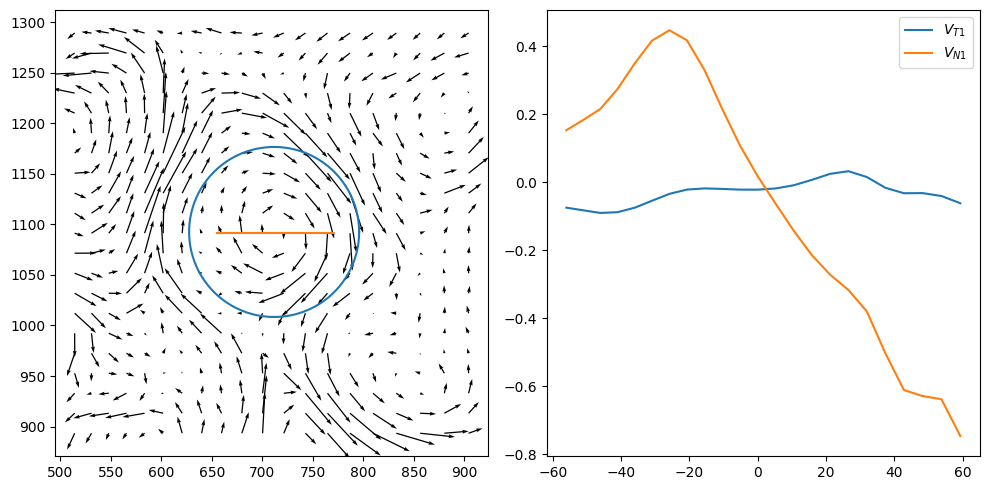

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

spacing = 4
quiv_scale = 10
axs[0].quiver(Xe[::spacing, ::spacing], Ye[::spacing, ::spacing], ue[::spacing, ::spacing], ve[::spacing, ::spacing],
             scale=quiv_scale)
x_ell, y_ell = plot_ellipse(np.array([[q11e, q12e], [q12e, q22e]]), center=(x0e, y0e), scale=100)
axs[0].plot(x_ell, y_ell)
axs[0].plot(x1e, y1e)
axs[0].axis('equal')

axs[1].plot(xxe, u1e, label=r'$V_{T1}$')
axs[1].plot(xxe, v1e, label=r'$V_{N1}$')
axs[1].legend()

plt.tight_layout()
plt.show()

In [7]:
u_dopioe, v_dopioe, X_dopioe, Y_dopioe = gaussian_vel_reconstruction(x0e, y0e, q11e, q12e, q22e, Rc_opt, psi0_opt)


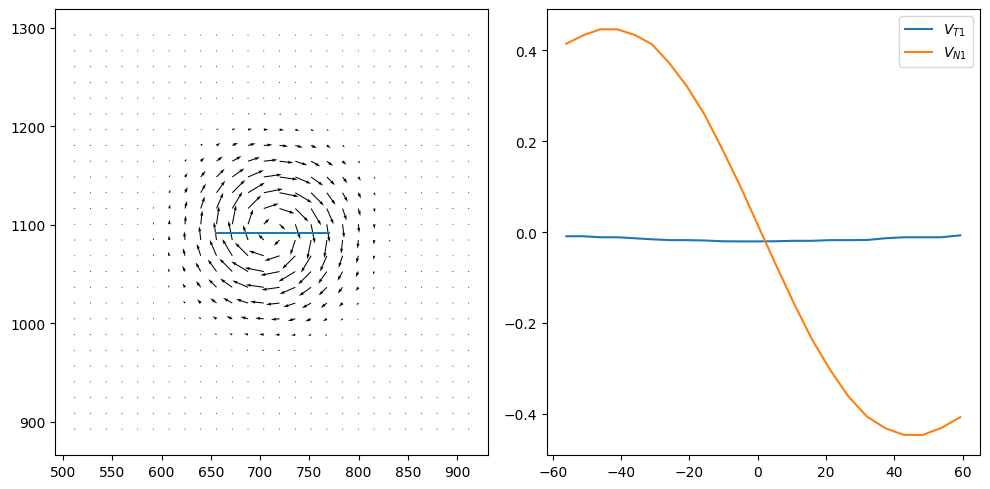

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

spacing = 2
quiv_scale = 10
axs[0].quiver(X_dopioe[::spacing, ::spacing], Y_dopioe[::spacing, ::spacing], u_dopioe[::spacing, ::spacing], v_dopioe[::spacing, ::spacing],
             scale=quiv_scale)
axs[0].plot(x1e, y1e)
axs[0].axis('equal')

points = np.column_stack((X_dopioe.ravel(), Y_dopioe.ravel()))
values_v, values_u = v_dopioe.ravel(), u_dopioe.ravel()
v1_dopioe = griddata(points, values_v, (x1e, y1e), method='linear')
u1_dopioe = griddata(points, values_u, (x1e, y1e), method='linear')

axs[1].plot(xxe, u1_dopioe, label=r'$V_{T1}$')
axs[1].plot(xxe, v1_dopioe, label=r'$V_{N1}$')
axs[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# for eddy in sample_eddies:
#     eddy = int(eddy[4:])

# eddy = 1967
# t = 10
df_Rc = pd.DataFrame(columns=['Rc', 'psi0', 'Depth'])
dic = {}
for k in range(len(dic_sample[f'Eddy{eddy}'][list(dic_sample[f'Eddy{eddy}'].keys())[t]])):
    dic[f'z{k}'] = {}
    dic_eddy_domain = extract_eddy_domain(eddy, t, dic_sample, df_eddies, mask_rho, X_grid, Y_grid, k=k)
    ue = dic_eddy_domain['u']
    ve = dic_eddy_domain['v']
    Xe = dic_eddy_domain['X']
    Ye = dic_eddy_domain['Y']
    q11e = dic_eddy_domain['q11']
    q12e = dic_eddy_domain['q12']
    q22e = dic_eddy_domain['q22']
    x0e = dic_eddy_domain['x0']
    y0e = dic_eddy_domain['y0']
    Depthe = dic_eddy_domain['Depth']
    
    dic_eddy_transect = extract_transect_center(ue, ve, Xe, Ye, x0e, y0e, r=60)
    x1e = dic_eddy_transect['x1']
    y1e = dic_eddy_transect['y1']
    u1e = dic_eddy_transect['u1']
    v1e = dic_eddy_transect['v1']
    xxe = dic_eddy_transect['xx']
    
    xi = x1e
    yi = y1e
    
    ui = u1e
    vi = v1e
    
    # NEGATIVE psi0_0 FOR AE
    # POSITIVE psi0_0 FOR CE
    Rc_opt, psi0_opt = espra_Rc(xi, yi, ui, vi, x0e, y0e, q11e, q12e, q22e)
    
    df_Rc.loc[len(df_Rc)] = {'Rc': Rc_opt, 'psi0': psi0_opt, 'Depth': Depthe}

    u_dopioe, v_dopioe, X_dopioe, Y_dopioe = gaussian_vel_reconstruction(x0e, y0e, q11e, q12e, q22e, Rc_opt, psi0_opt)
    dic[f'z{k}']['u'] = u_dopioe
    dic[f'z{k}']['v'] = v_dopioe
    dic[f'z{k}']['X'] = X_dopioe
    dic[f'z{k}']['Y'] = Y_dopioe
    dic[f'z{k}']['Depth'] = z_r[k]

df_Rc


q11: -0.007861735038223051, q12: 0, q22: -0.007861735038223051
q11: -0.007889929047774122, q12: 0, q22: -0.007889929047774122
q11: -0.0075662118744946084, q12: 0, q22: -0.0075662118744946084
q11: -0.007439626491674066, q12: 0, q22: -0.007439626491674066
q11: -0.007223958883974824, q12: 0, q22: -0.007223958883974824
q11: -0.00681995501857066, q12: 0, q22: -0.00681995501857066
q11: -0.006691207855994839, q12: 0, q22: -0.006691207855994839
q11: -0.006905101820179338, q12: 0, q22: -0.006905101820179338
q11: -0.006924276606362868, q12: 0, q22: -0.006924276606362868
q11: -0.006693343245141781, q12: 0, q22: -0.006693343245141781
q11: -0.006411726332657996, q12: 0, q22: -0.006411726332657996
q11: -0.006035515767833646, q12: 0, q22: -0.006035515767833646
q11: -0.005748155762346778, q12: 0, q22: -0.005748155762346778
q11: -0.00536414662950605, q12: 0, q22: -0.00536414662950605
q11: -0.004953612116153067, q12: 0, q22: -0.004953612116153067
q11: -0.004428349598936111, q12: 0, q22: -0.0044283495989

,Rc,psi0,Depth
0,5.621162,32.764555,-1.783320
1,5.242894,29.949974,-5.879627
2,5.495362,33.106199,-10.725783
3,6.469413,44.104890,-16.383097
4,6.143054,41.178819,-22.925581
5,5.884697,39.405572,-30.444118
6,5.787839,38.099046,-39.052712
7,5.944315,38.943121,-48.897638
8,5.930334,38.251588,-60.170639
9,5.862147,37.520424,-73.127842


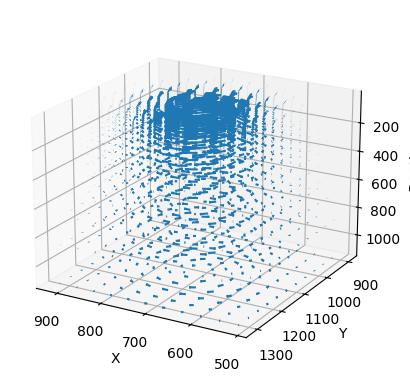

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

spacing = 5
scale_factor = 100  # adjust arrow length

for key in dic:
    d = dic[key]
    XX = d['X'][::spacing, ::spacing]
    YY = d['Y'][::spacing, ::spacing]
    ZZ = -d['Depth']
    UU = d['u'][::spacing, ::spacing] * scale_factor
    VV = d['v'][::spacing, ::spacing] * scale_factor
    WW = np.zeros_like(UU)

    ax.quiver(XX, YY, ZZ, UU, VV, WW)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')
ax.invert_zaxis()
ax.view_init(elev=20, azim=120)

plt.show()



### Generate Gridded Velocity Field

In [11]:
from scipy.interpolate import griddata

# 1) collect all (x,y,z) points and their u,v values
pts = []
uvals = []
vvals = []
for d in dic.values():
    X = d['X'].ravel()
    Y = d['Y'].ravel()
    Z = -d['Depth'] * np.ones_like(X)
    pts.append(np.column_stack((X, Y, Z)))
    uvals.append((d['u'] * scale_factor).ravel())
    vvals.append((d['v'] * scale_factor).ravel())

pts   = np.vstack(pts)
uvals = np.concatenate(uvals)
vvals = np.concatenate(vvals)

# 2) choose your new grid resolution
nz = len(dic)
ny = max(d['X'].shape[0] for d in dic.values()) // 2 # Halve Resolution
nx = max(d['X'].shape[1] for d in dic.values()) // 2

xi = np.linspace(pts[:,0].min(), pts[:,0].max(), nx)
yi = np.linspace(pts[:,1].min(), pts[:,1].max(), ny)
zi = np.linspace(pts[:,2].min(), pts[:,2].max(), nz)
# zi = -z_r[:np.sort([int(a[1:]) for a in dic.keys()]).max()+1]

Xg, Yg, Zg = np.meshgrid(xi, yi, zi, indexing='xy')
grid_pts   = np.column_stack((Xg.ravel(), Yg.ravel(), Zg.ravel()))

# 3) interpolate onto the cube
U = griddata(pts, uvals, grid_pts, method='linear', fill_value=0)
V = griddata(pts, vvals, grid_pts, method='linear', fill_value=0)
# W = np.zeros_like(U)

# 4) reshape back to 3D
U = U.reshape(Xg.shape)
V = V.reshape(Xg.shape)
# W = W.reshape(Xg.shape)


In [12]:
W = solve_w(U, V, xi, yi, zi)

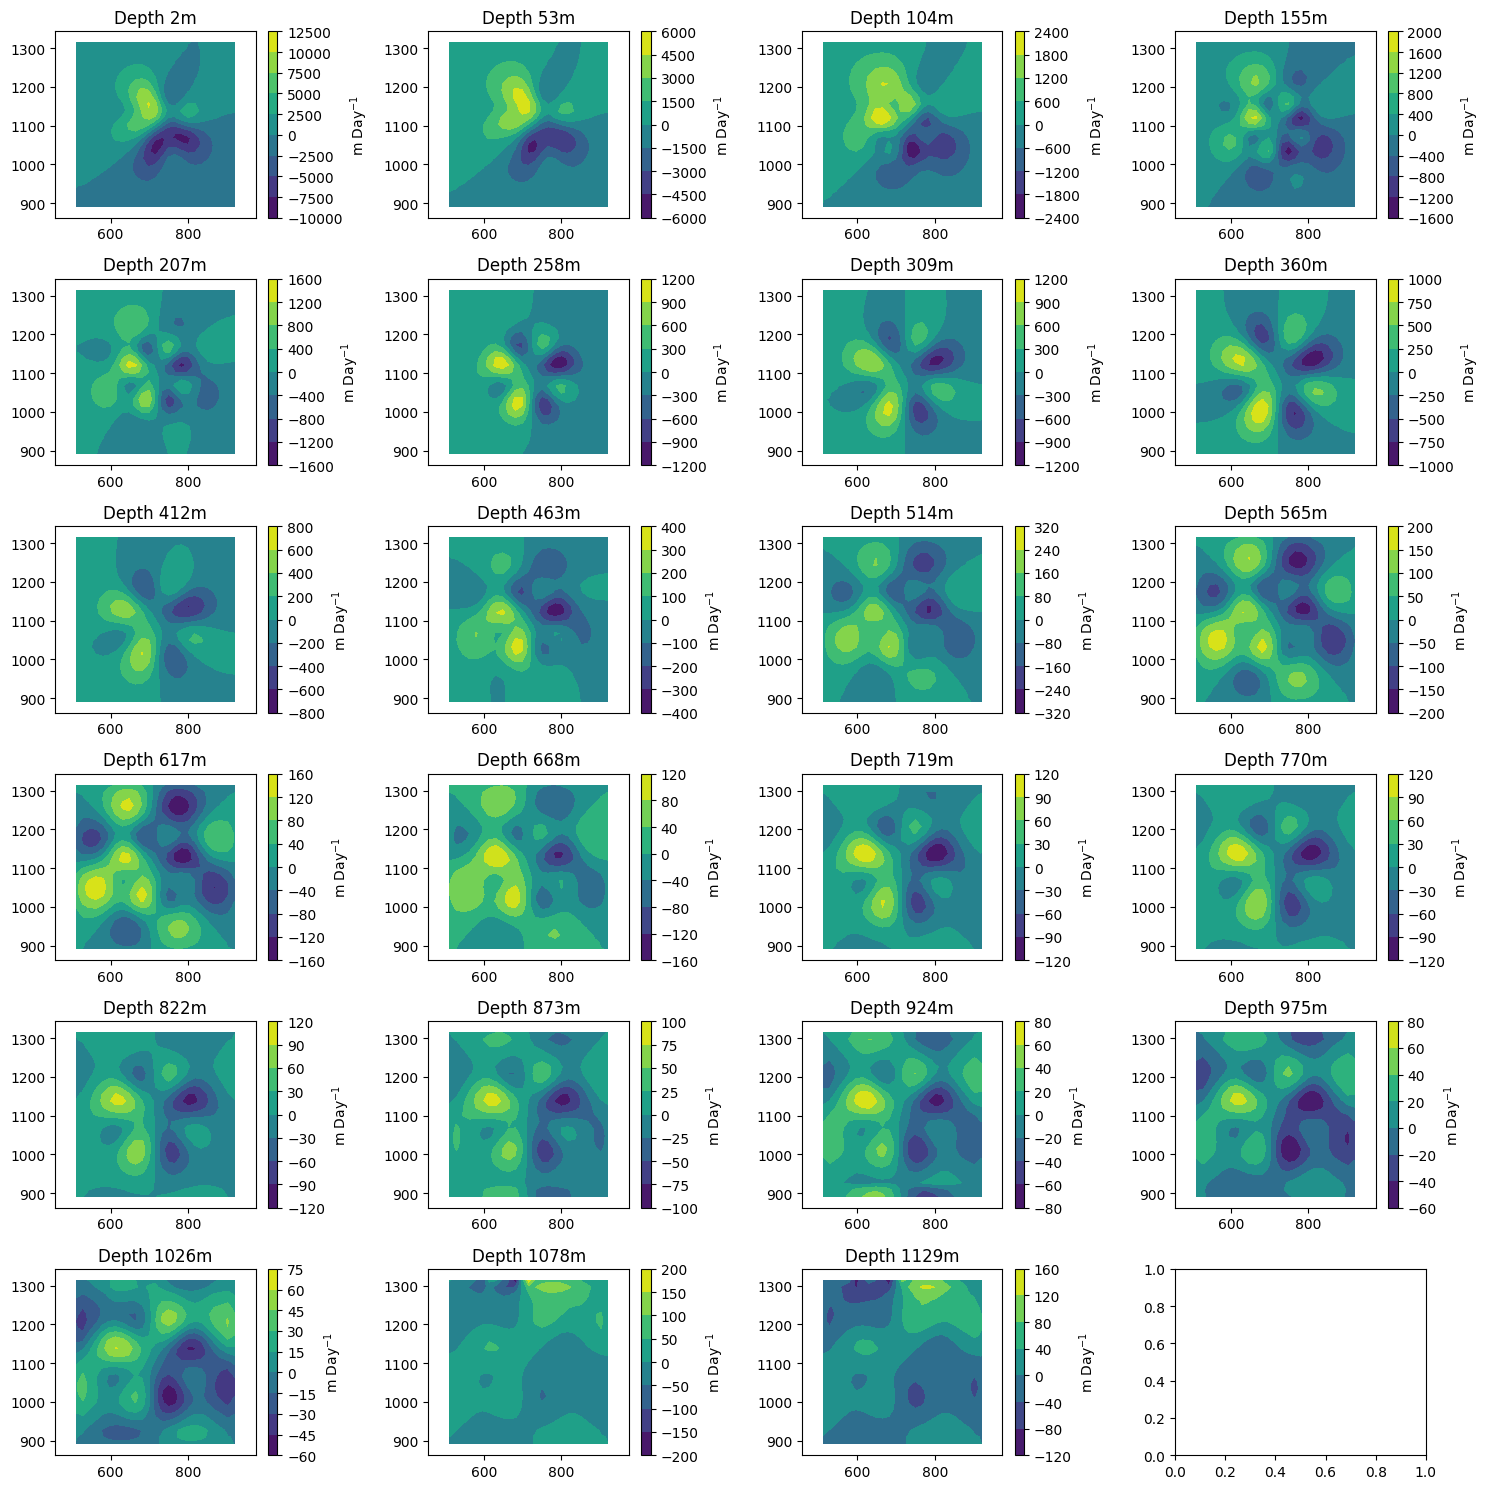

In [13]:
fig, axs = plt.subplots(6, 4, figsize=(15, 15))
for p in range(W.shape[-1]):
    ax = axs[p // 4, p % 4]
    cf = ax.contourf(xi, yi, W[:, :, p] * 86400 )
    ax.axis('equal')
    ax.set_title(f'Depth {round(zi[p])}m')
    fig.colorbar(cf, ax=ax, label=r'm Day$^{-1}$')
plt.tight_layout()
plt.show()


### $\sigma_{OW}$

In [14]:
def calc_ow(uu, vv, dx, dy, flag=True):
    WIDTH, LENGTH, SIGMAS = uu.shape

    if flag:
        for k in range(SIGMAS):
            uu[:,:,k] = uu[:,:,k].T
            vv[:,:,k] = vv[:,:,k].T
    
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std


In [15]:
dx = np.diff(xi)[0]
dy = np.diff(yi)[0]

ow = calc_ow(U, V, dx*1000, dy*1000)
sigma_ow = normalize_matrix(ow)


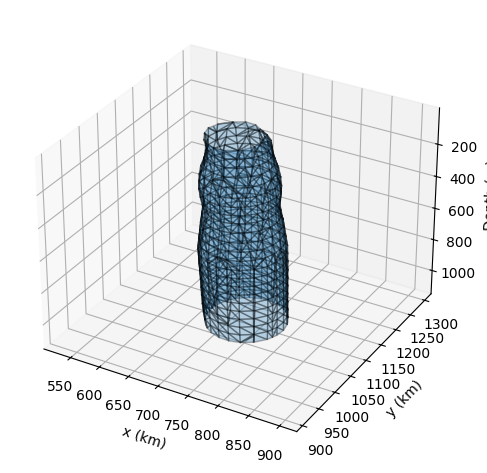

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from scipy.ndimage import map_coordinates

# ---- assume you already have ----
# sigma_ow : 3D numpy array of your scalar field
# Xg, Yg, Zg : 3D numpy arrays (same shape as sigma_ow)
# ---------------------------------

# 1. extract isosurface in index-space
verts, faces, normals, values = marching_cubes(sigma_ow, level=-0.2)

# 2. map each index‐space vertex into your real-world coords
#    verts is (Nverts, 3), columns = (i, j, k)
#    map_coordinates expects coordinates as (dim, Npoints)
pts = verts.T  # shape (3, Nverts)

# interpolate each coordinate array at those fractional indices
real_x = map_coordinates(Xg, pts, order=1)
real_y = map_coordinates(Yg, pts, order=1)
real_z = map_coordinates(Zg, pts, order=1)

# stack back into (Nverts, 3)
real_verts = np.vstack((real_x, real_y, real_z)).T

# 3. plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mesh = Poly3DCollection(real_verts[faces], alpha=0.3)
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

# # optionally plot quiver of your velocity vectors (downsampled)
# step = 5
# ax.quiver(
#     Xg[::step,::step,::step],
#     Yg[::step,::step,::step],
#     Zg[::step,::step,::step],
#     U[::step,::step,::step],  # replace Ui, Vi, Wi with your vector components
#     V[::step,::step,::step],
#     W[::step,::step,::step],
#     length=10, normalize=True,  # adjust as needed
#     linewidths=0.5
# )

# 4. set axes limits to the extents of your grid
ax.set_xlim(Xg.min(), Xg.max())
ax.set_ylim(Yg.min(), Yg.max())
ax.set_zlim(Zg.min(), Zg.max())

# if you still want z inverted:
ax.invert_zaxis()

ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (m)')

plt.tight_layout()
plt.show()



### Original

In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
dic_orig = {}
for k in range(len(dic)):
    dic_orig[f'z{k}'] = {}
    dic_eddy_domain = extract_eddy_domain(eddy, t, dic_sample, df_eddies, mask_rho, X_grid, Y_grid, k=k)
    
    dic_orig[f'z{k}']['u'] = dic_eddy_domain['u']
    dic_orig[f'z{k}']['v'] = dic_eddy_domain['v']
    dic_orig[f'z{k}']['X'] = dic_eddy_domain['X']
    dic_orig[f'z{k}']['Y'] = dic_eddy_domain['Y']
    dic_orig[f'z{k}']['Depth'] = - dic_eddy_domain['Depth']

    # print(f'Eddy{eddy} t{t}')
    # print(df_Rce)

In [ ]:
import numpy as np
from scipy.interpolate import griddata

# 1) collect all (x,y,z) points and their u,v values
pts = []
uvals = []
vvals = []
for d in dic_orig.values():
    X = d['X'].ravel()
    Y = d['Y'].ravel()
    Z = d['Depth'] * np.ones_like(X)
    pts.append(np.column_stack((X, Y, Z)))
    uvals.append((d['u'] * scale_factor).ravel())
    vvals.append((d['v'] * scale_factor).ravel())

pts   = np.vstack(pts)
uvals = np.concatenate(uvals)
vvals = np.concatenate(vvals)

# 2) choose your new grid resolution
nz = len(dic_orig)
ny = max(d['X'].shape[0] for d in dic_orig.values()) // 5
nx = max(d['X'].shape[1] for d in dic_orig.values()) // 5

xi_orig = np.linspace(pts[:,0].min(), pts[:,0].max(), nx)
yi_orig = np.linspace(pts[:,1].min(), pts[:,1].max(), ny)
# zi = np.linspace(pts[:,2].min(), pts[:,2].max(), nz)
zi_orig = -z_r[:np.sort([int(a[1:]) for a in dic_orig.keys()]).max()+1]

Xg_orig, Yg_orig, Zg_orig = np.meshgrid(xi_orig, yi_orig, zi_orig, indexing='xy')
grid_pts   = np.column_stack((Xg_orig.ravel(), Yg_orig.ravel(), Zg_orig.ravel()))

# 3) interpolate onto the cube
U_orig = griddata(pts, uvals, grid_pts, method='linear', fill_value=0)
V_orig = griddata(pts, vvals, grid_pts, method='linear', fill_value=0)
# W = np.zeros_like(U)

# 4) reshape back to 3D
U_orig = U_orig.reshape(Xg_orig.shape)
V_orig = V_orig.reshape(Xg_orig.shape)
# W = W.reshape(Xg.shape)


In [ ]:
dx_orig = np.diff(xi_orig)[0]
dy_orig = np.diff(yi_orig)[0]

ow_orig = calc_ow(U_orig, V_orig, dx_orig*1000, dy_orig*1000, flag=False)
sigma_ow_orig = normalize_matrix(ow_orig)


In [ ]:
# ---- assume you already have ----
# sigma_ow : 3D numpy array of your scalar field
# Xg, Yg, Zg : 3D numpy arrays (same shape as sigma_ow)
# ---------------------------------

# 1. extract isosurface in index-space
verts, faces, normals, values = marching_cubes(sigma_ow_orig, level=-0.2)

# 2. map each index‐space vertex into your real-world coords
#    verts is (Nverts, 3), columns = (i, j, k)
#    map_coordinates expects coordinates as (dim, Npoints)
pts = verts.T  # shape (3, Nverts)

# interpolate each coordinate array at those fractional indices
real_x = map_coordinates(Xg_orig, pts, order=1)
real_y = map_coordinates(Yg_orig, pts, order=1)
real_z = map_coordinates(Zg_orig, pts, order=1)

# stack back into (Nverts, 3)
real_verts = np.vstack((real_x, real_y, real_z)).T

# 3. plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mesh = Poly3DCollection(real_verts[faces], alpha=0.3)
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

# # optionally plot quiver of your velocity vectors (downsampled)
# step = 5
# ax.quiver(
#     Xg[::step,::step,::step],
#     Yg[::step,::step,::step],
#     Zg[::step,::step,::step],
#     U[::step,::step,::step],  # replace Ui, Vi, Wi with your vector components
#     V[::step,::step,::step],
#     W[::step,::step,::step],
#     length=10, normalize=True,  # adjust as needed
#     linewidths=0.5
# )

# 4. set axes limits to the extents of your grid
ax.set_xlim(Xg_orig.min(), Xg_orig.max())
ax.set_ylim(Yg_orig.min(), Yg_orig.max())
ax.set_zlim(Zg_orig.min(), Zg_orig.max())

# if you still want z inverted:
ax.invert_zaxis()

ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (m)')

ax.view_init(elev=30, azim=10)
plt.tight_layout()
plt.show()



In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

spacing = 10
scale_factor = 10  # adjust arrow length

for key in dic_orig:
    d = dic_orig[key]
    XX = d['X'][::spacing, ::spacing]
    YY = d['Y'][::spacing, ::spacing]
    ZZ = d['Depth']
    UU = d['u'][::spacing, ::spacing] * scale_factor
    VV = d['v'][::spacing, ::spacing] * scale_factor
    WW = np.zeros_like(UU)

    ax.quiver(XX, YY, ZZ, UU, VV, WW, length=scale_factor)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')
ax.invert_zaxis()
intt = 100
ax.set_xlim(650-intt, 800+intt)
ax.set_ylim(1050-intt, 1150+intt)
ax.view_init(elev=20, azim=120)

plt.show()